In [2]:
# Has multi-dimensional arrays and matrices.
# Has a large collection of mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# Data visualization tools.
import seaborn as sns

import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.discrete_space.property_layer import PropertyLayer
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle, PropertyLayerStyle

In [3]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(CellAgent):

    def __init__(self, model, cell):
        
        super().__init__(model)
        self.cell = cell
        self.wealth = 1

    def move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        cellmates = [a for a in self.cell.agents if a is not self]

        if cellmates:  # Only give money if there are other agents present
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):

    def __init__(self, n=10, width=10, height=10, seed=None):
        
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid((width, height), random=self.random)

        # Add a test property layer with random data
        test_layer = PropertyLayer(
            "test layer", (width, height), default_value=0, dtype=int
        )
        test_layer.data = np.random.randint(0, 10, size=(width, height))
        self.grid.add_property_layer(test_layer)

        # Create agents
        MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )
        self.datacollector.collect(self)

    def step(self):
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

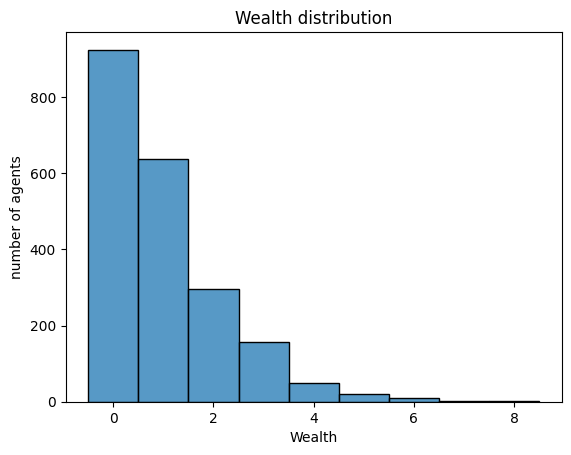

In [4]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()


data = model.datacollector.get_agent_vars_dataframe()
# Use seaborn
g = sns.histplot(data["Wealth"], discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

In [5]:
model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

In [6]:
plot_comp = make_plot_component("encoding", page=1)

In [7]:
@solara.component
def CustomComponent():
    ...

page = SolaraViz(
    model,
    renderer,
    components=[(CustomComponent, 1)]  # Custom component will appear on page 1
)

NameError: name 'solara' is not defined

In [8]:
def propertylayer_portrayal(layer):
    if layer.name == "WealthDensity":
        return PropertyLayerStyle(
            colormap="viridis",
            alpha=0.6,
            colorbar=True,
            vmin=0,
            vmax=10,
        )
    elif layer.name == "Temperature":
        return PropertyLayerStyle(
            colormap="coolwarm",
            alpha=0.5,
            colorbar=False,
            vmin=-1,
            vmax=1,
        )

In [9]:
def agent_portrayal(agent):
    portrayal = AgentPortrayalStyle(size=50, color="orange")
    if agent.wealth > 0:
        portrayal.update(("color", "blue"), ("size", 100))
    return portrayal


def propertylayer_portrayal(layer):
    if layer.name == "test layer":
        return PropertyLayerStyle(color="blue", alpha=0.8, colorbar=True)


# Create initial model instance
money_model = MoneyModel(n=50, width=10, height=10)

In [10]:
%%capture

renderer = SpaceRenderer(model=money_model, backend="matplotlib")
renderer.draw_structure(lw=2, ls="solid", color="black", alpha=0.1)
renderer.draw_agents(agent_portrayal)
renderer.draw_propertylayer(propertylayer_portrayal)

In [11]:
%%capture

renderer = SpaceRenderer(model=money_model, backend="matplotlib")
renderer.render(
    space_kwargs={  # an alternative way to customize the grid structure
        "lw": 2,
        "ls": "solid",
        "color": "black",
        "alpha": 0.1,
    },
    agent_portrayal=agent_portrayal,
    propertylayer_portrayal=propertylayer_portrayal,
)

In [12]:
def post_process(ax):
    """Customize the matplotlib axes after rendering."""
    ax.set_title("Boltzmann Wealth Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_aspect("equal", adjustable="box")


renderer.post_process = post_process


def post_process_lines(ax):
    """Customize the matplotlib axes for the Gini line plot."""
    ax.set_title("Gini Coefficient Over Time")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Gini Coefficient")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_aspect("auto")


GiniPlot = make_plot_component("Gini", post_process=post_process_lines)

In [13]:
page = SolaraViz(
    money_model,
    renderer,
    components=[GiniPlot],
    model_params=model_params,
    name="Boltzmann Wealth Model",
)

# This is required to render the visualization in a Jupyter notebook
page

Cannot show ipywidgets in text

<Figure size 640x480 with 0 Axes>